## Automatic Panorama Mosaicing

In [1]:
%matplotlib inline

import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform, resize
from skimage.color import rgb2gray
from skimage.measure import ransac
from skimage.filters import gaussian

Feature detection and matching:

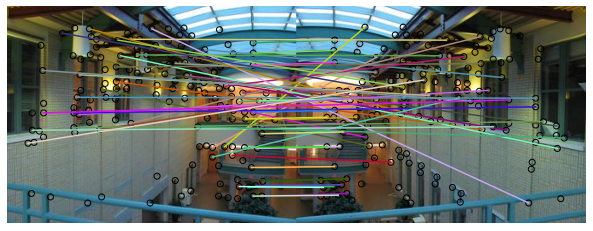

In [2]:
imL = image.imread("images/CMU_left.jpg")
imR = image.imread("images/CMU_right.jpg")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.0005, min_distance=5)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.0005, min_distance=5)

extractor = BRIEF()

extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask]
descriptorsL = extractor.descriptors

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)

fig = plt.figure(1,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

Estimating homography using RANSAC to find inlier matches

Found 23 inliers


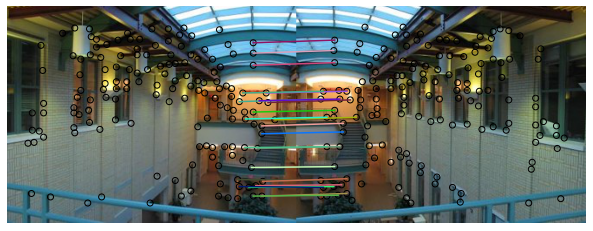

In [3]:
THRESHOLD = 15
MAX_ITER = 130

src = [] # LEFT image points
dst = [] # RIGHT image points

for match in matchesLR:
    src.append(np.flip(keypointsL[match[0]]))
    dst.append(np.flip(keypointsR[match[1]]))

src = np.array(src)
dst = np.array(dst)

model_robust, inliers = ransac((src,dst), ProjectiveTransform, min_samples=3,
                               residual_threshold=THRESHOLD, max_trials=MAX_ITER)
print(f"Found {np.count_nonzero(inliers)} inliers")

good_matchesLR = matchesLR[inliers]

fig = plt.figure(2,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, good_matchesLR) 
axA.axis('off')

plt.show()

Reprojecting left and right images onto common plane:

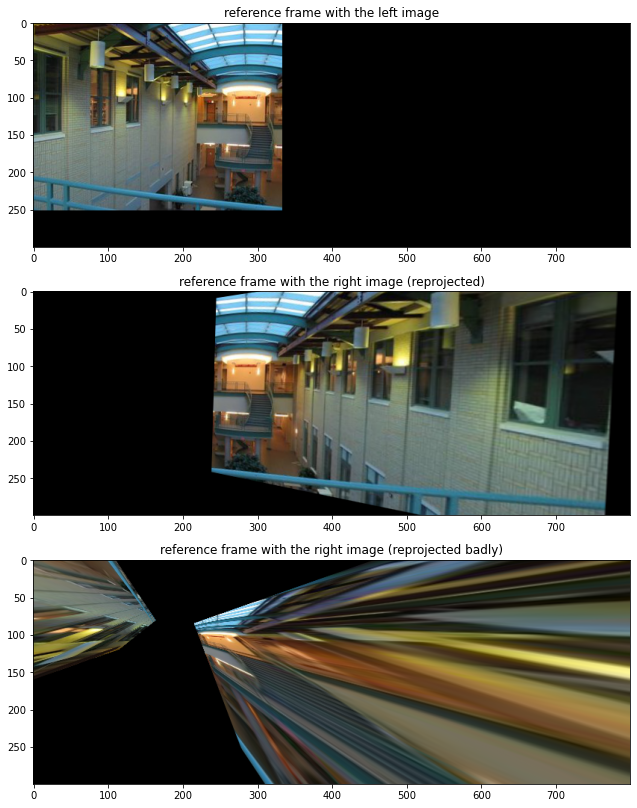

In [4]:
fig = plt.figure(3,figsize = (12, 14))
plt.subplot(311)
warpedL = warp(imL, ProjectiveTransform(matrix=np.identity(3)), output_shape=(300, 800))
plt.imshow(warpedL)
plt.title("reference frame with the left image")

plt.subplot(312)
warpedR = warp(imR, model_robust, output_shape=(300, 800))
plt.imshow(warpedR)
plt.title("reference frame with the right image (reprojected)")

bad_model = ransac((src,dst), ProjectiveTransform, min_samples=3,
                               residual_threshold=300, max_trials=MAX_ITER)[0]
warped_bad = warp(imR, bad_model, output_shape=(300, 800))
plt.subplot(313)
plt.imshow(warped_bad)
plt.title("reference frame with the right image (reprojected badly)")

plt.show()

Blending images using distance transform

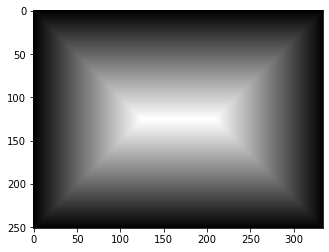

In [5]:
def boundaryDT(image):
    shape = image.shape[:2]
    dtrans = np.ndarray(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            dtrans[i,j] = min(i, shape[0]-i, j, shape[1]-j)
    return dtrans

res = boundaryDT(imL)
fig = plt.figure(figsize = (12, 4))
plt.gray()
plt.imshow(res)
plt.show()

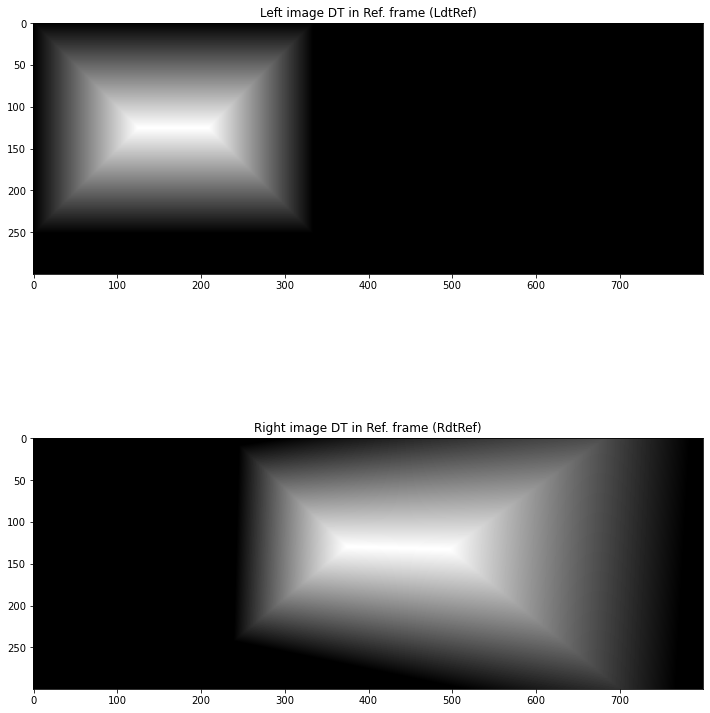

In [6]:
fig = plt.figure(4,figsize = (12, 14))
plt.subplot(211)
dtrans = boundaryDT(imL)
dtransL = warp(dtrans, ProjectiveTransform(matrix=np.identity(3)), output_shape=(300, 800))
plt.imshow(dtransL)
plt.title("Left image DT in Ref. frame (LdtRef)")

plt.subplot(212)
dtransR = warp(dtrans, model_robust, output_shape=(300, 800))
plt.imshow(dtransR)
plt.title("Right image DT in Ref. frame (RdtRef)")
plt.show()

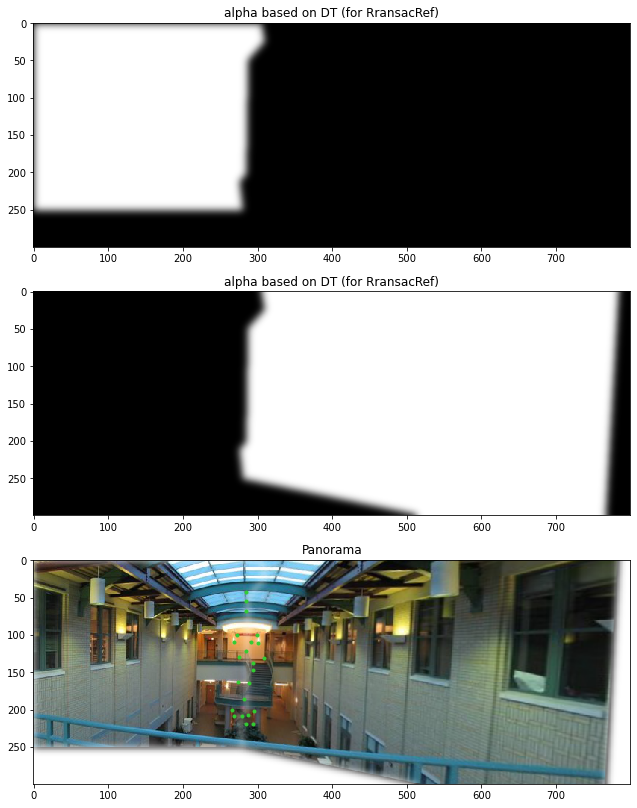

In [7]:
BLUR = 5

fig = plt.figure(5,figsize = (12, 14))
plt.subplot(311)
alphaL = np.ma.masked_array(dtransL>dtransR)
alphaL = gaussian(alphaL, sigma = BLUR)
plt.imshow(alphaL)
plt.title("alpha based on DT (for RransacRef)")

plt.subplot(312)
alphaR = np.ma.masked_array(dtransR>dtransL)
alphaR = gaussian(alphaR, sigma = BLUR)
plt.imshow(alphaR)
plt.title("alpha based on DT (for RransacRef)")

plt.subplot(313)

#for some reason this didn't work:
# alphaL = np.divide(dtransL, (dtransL+dtransR))
# alphaR = np.divide(dtransR, (dtransL+dtransR))
# plt.imshow(warpedR, alpha=alphaR)
# plt.imshow(warpedL, alpha=alphaL)

inliersL = keypointsL[good_matchesLR[:,0]]
XL = inliersL[:,1]
YL = inliersL[:,0]

inliersR = keypointsR[good_matchesLR[:,1]]
inliersR = np.squeeze(np.array([model_robust(coord) for coord in inliersR]))
XR = inliersR[:,1]
YR = inliersR[:,0]

plt.imshow(np.dstack((warpedL, alphaL)), interpolation='none')
plt.imshow(np.dstack((warpedR, alphaR)), interpolation='none')

plt.scatter(XL,YL, marker=".", color = "limegreen")
# plt.scatter(XR,YR, marker=".", color = "red")

plt.title("Panorama")

plt.show()